In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
import seaborn as sns

In [61]:
df = pd.read_csv('data/processed/train.csv')

C:\Users\LEGION\AppData\Local\Temp\ipykernel_27608\247379734.py:1: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/train.csv')


In [62]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [63]:
df = reduce_memory_usage(df)

Mem. usage decreased to 781.94 Mb (53.6% reduction)


In [64]:
def clean_dataset(df):
    """
    Clean and preprocess the banking dataset
    
    Parameters:
    df: pandas DataFrame - Raw dataset
    
    Returns:
    df: pandas DataFrame - Cleaned dataset
    """
    
    print("🧹 CLEANING DATASET...")
    print("="*40)
    
    # =============================
    # 1. HANDLE MISSING VALUES
    # =============================
    print("1️⃣ Handling missing values...")
    
    # Fill missing values for payroll indicators
    # These columns indicate if customer has payroll/pension products
    missing_before = df[['payroll_final_label', 'pensions_2_final_label']].isnull().sum()
    df.fillna(value={
        'payroll_final_label': 0,
        'pensions_2_final_label': 0
    }, inplace=True)
    
    print(f"   ✅ Filled payroll_final_label: {missing_before['payroll_final_label']} missing → 0")
    print(f"   ✅ Filled pensions_2_final_label: {missing_before['pensions_2_final_label']} missing → 0")
    
    # =============================
    # 2. CREATE CUSTOMER TENURE FEATURE
    # =============================
    print("\n2️⃣ Creating customer tenure feature...")
    
    # Convert date columns to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['registration_date'] = pd.to_datetime(df['registration_date'])
    
    # Calculate days since registration (customer tenure)
    days_column = (df['date'] - df['registration_date']).dt.days
    
    # Insert the new column at position 6
    df.insert(loc=6, column='customer_tenure_days', value=days_column)
    
    print(f"   ✅ Created 'customer_tenure_days' feature")
    print(f"   📊 Range: {days_column.min()} to {days_column.max()} days")
    
    # Drop the original registration_date column to save memory
    df.drop(columns=['registration_date'], inplace=True)
    print(f"   🗑️ Dropped 'registration_date' column")
    
    # =============================
    # 3. CONVERT LAST_PRIMARY_DATE TO BINARY INDICATOR
    # =============================
    print("\n3️⃣ Converting last_primary_date to binary indicator...")
    
    # Convert last_primary_date to binary: 1 if date exists, 0 if null
    # This indicates if customer was ever a primary customer
    original_nulls = df['last_primary_date'].isnull().sum()
    df['was_primary_customer'] = df['last_primary_date'].apply(
        lambda x: 1 if pd.notnull(x) else 0
    )
    
    print(f"   ✅ Created 'was_primary_customer' binary feature")
    print(f"   📊 {original_nulls:,} nulls → 0, {len(df) - original_nulls:,} dates → 1")
    
    # Drop the original last_primary_date column
    df.drop(columns=['last_primary_date'], inplace=True)
    print(f"   🗑️ Dropped 'last_primary_date' column")
    
    # =============================
    # 4. REMOVE CONSTANT/DUPLICATE COLUMNS
    # =============================
    print("\n4️⃣ Removing constant and duplicate columns...")
    
    # Remove address_type if it has the same value for all customers
    if 'address_type' in df.columns:
        unique_values = df['address_type'].nunique()
        if unique_values <= 1:
            df.drop(columns=['address_type'], inplace=True)
            print(f"   🗑️ Dropped 'address_type' (constant value)")
        else:
            print(f"   ✅ Kept 'address_type' ({unique_values} unique values)")
    
    # Remove province_code as it's duplicate of province_name
    if 'province_code' in df.columns and 'province_name' in df.columns:
        df.drop(columns=['province_code'], inplace=True)
        print(f"   🗑️ Dropped 'province_code' (duplicate of province_name)")
    
    # =============================
    # 5. CLEAN NUMERIC COLUMNS
    # =============================
    print("\n5️⃣ Cleaning numeric columns...")
    
    # Convert age column - handle 'NA' strings
    if 'age' in df.columns:
        age_before = df['age'].dtype
        df['age'] = pd.to_numeric(df['age'], errors='coerce')
        age_nulls = df['age'].isnull().sum()
        print(f"   ✅ Cleaned 'age': {age_before} → numeric ({age_nulls:,} nulls)")
    
    # Convert seniority column - handle 'NA' strings and negative values
    if 'seniority' in df.columns:
        seniority_before = df['seniority'].dtype
        df['seniority'] = pd.to_numeric(df['seniority'], errors='coerce')
        
        # Handle special negative values (often -999999 means missing)
        negative_values = (df['seniority'] < 0).sum()
        if negative_values > 0:
            df['seniority'] = df['seniority'].where(df['seniority'] >= 0, np.nan)
            print(f"   ⚠️ Converted {negative_values:,} negative seniority values to NaN")
        
        seniority_nulls = df['seniority'].isnull().sum()
        print(f"   ✅ Cleaned 'seniority': {seniority_before} → numeric ({seniority_nulls:,} nulls)")
    
    # =============================
    # 6. SUMMARY STATISTICS
    # =============================
    print("\n📊 CLEANUP SUMMARY:")
    print("-" * 40)
    print(f"   Final shape: {df.shape}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"   Null values: {df.isnull().sum().sum():,}")
    
    # Show data types
    print(f"\n📋 DATA TYPES AFTER CLEANUP:")
    for dtype in df.dtypes.value_counts().index:
        count = df.dtypes.value_counts()[dtype]
        print(f"   {dtype}: {count} columns")
    
    return df


In [65]:

payment_account_labels = [
    'current_accounts_final_label',
    'payroll_accounts_final_label',
    'junior_accounts_final_label',
    'more_particular_accounts_final_label',
    'particular_accounts_final_label',
    'particular_plus_accounts_final_label',
    'home_account_final_label',
    'payroll_final_label',
    'e_account_final_label'
]

customer_features = [
    'date', 'customer_id', 'employee_index', 'country_of_residence', 'gender',
    'age', 'customer_tenure_days', 'seniority', 'residence_index',  # Added customer_tenure_days
    'foreigner_index', 'spouse_index', 'channel', 'deceased_index', 
    'province_name', 'segment', 'was_primary_customer'  # Added was_primary_customer
]
def filter_data(df) :
    # Lấy khách hàng không có tài khoản thanh toán nào (không có giá trị -1)
    mask = ~(df[payment_account_labels] == -1).any(axis=1)
    
    # Các cột cần giữ lại
    columns_to_keep = customer_features + payment_account_labels
    
    # Lọc dữ liệu
    df = df.loc[mask, columns_to_keep]
    
    print(f"Tổng số khách hàng: {len(df):,}")
    print(f"Khách hàng KHÔNG sở hữu tài khoản thanh toán nào: {len(df):,}")
    
    # Kiểm tra distribution
    print("\n📊 Distribution check:")
    for col in payment_account_labels:
        unique_vals = df[col].unique()
        print(f"  {col}: {unique_vals}")
    
    return df

In [66]:
df_cleaned = filter_data( clean_dataset(df.copy()))

# Verify the changes
print(f"\n✅ DATASET CLEANING COMPLETED!")
print(f"Original columns: {df.shape[1]}")
print(f"Cleaned columns: {df_cleaned.shape[1]}")
print(f"Columns removed: {df.shape[1] - df_cleaned.shape[1]}")

# Show new columns created
new_columns = set(df_cleaned.columns) - set(df.columns)
if new_columns:
    print(f"New columns created: {list(new_columns)}")

# Update the main dataframe
df = df_cleaned

🧹 CLEANING DATASET...
1️⃣ Handling missing values...
   ✅ Filled payroll_final_label: 0 missing → 0
   ✅ Filled pensions_2_final_label: 0 missing → 0

2️⃣ Creating customer tenure feature...
   ✅ Created 'customer_tenure_days' feature
   📊 Range: -3.0 to 7498.0 days
   🗑️ Dropped 'registration_date' column

3️⃣ Converting last_primary_date to binary indicator...
   ✅ Created 'was_primary_customer' binary feature
   📊 4,600,165 nulls → 0, 6,146 dates → 1
   🗑️ Dropped 'last_primary_date' column

4️⃣ Removing constant and duplicate columns...
   🗑️ Dropped 'address_type' (constant value)
   🗑️ Dropped 'province_code' (duplicate of province_name)

5️⃣ Cleaning numeric columns...
   ✅ Cleaned 'age': object → numeric (27,734 nulls)
   ⚠️ Converted 14 negative seniority values to NaN
   ✅ Cleaned 'seniority': object → numeric (27,748 nulls)

📊 CLEANUP SUMMARY:
----------------------------------------
   Final shape: (4606311, 46)
   Memory usage: 2935.7 MB
   Null values: 5,979,487

📋 DATA T

# Multivariate anlysis

In [67]:
target_cols = [
    "savings_account_final_label",
    "guarantees_final_label",
    "current_accounts_final_label",
    "deriv_investments_final_label",
    "payroll_accounts_final_label",
    "junior_accounts_final_label",
    "more_particular_accounts_final_label",
    "particular_accounts_final_label",
    "particular_plus_accounts_final_label",
    "short_term_deposits_final_label",
    "medium_term_deposits_final_label",
    "long_term_deposits_final_label",
    "e_account_final_label",
    "funds_final_label",
    "mortgage_final_label",
    "pensions_final_label",
    "loans_final_label",
    "taxes_final_label",
    "credit_card_final_label",
    "securities_final_label",
    "home_account_final_label",
    "payroll_final_label",
    "pensions_2_final_label",
    "direct_debit_final_label"
]

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442736 entries, 3 to 4606305
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   date                                  442736 non-null  datetime64[ns]
 1   customer_id                           442736 non-null  int32         
 2   employee_index                        415002 non-null  object        
 3   country_of_residence                  415002 non-null  object        
 4   gender                                414987 non-null  object        
 5   age                                   415002 non-null  float64       
 6   customer_tenure_days                  415002 non-null  float64       
 7   seniority                             414995 non-null  float64       
 8   residence_index                       415002 non-null  object        
 9   foreigner_index                       415002 non-null  object  

Column savings_account_final_label not found in DataFrame.
Column guarantees_final_label not found in DataFrame.


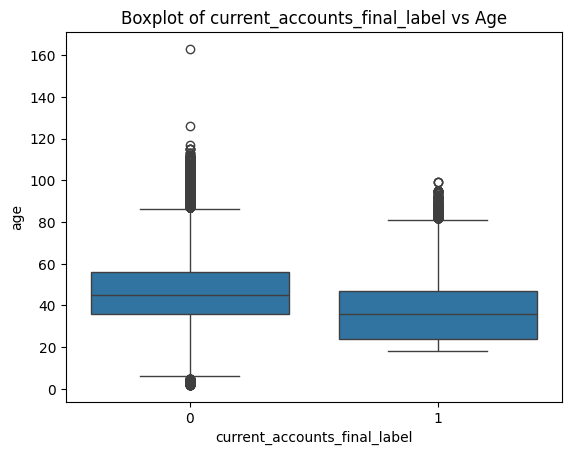

Column deriv_investments_final_label not found in DataFrame.


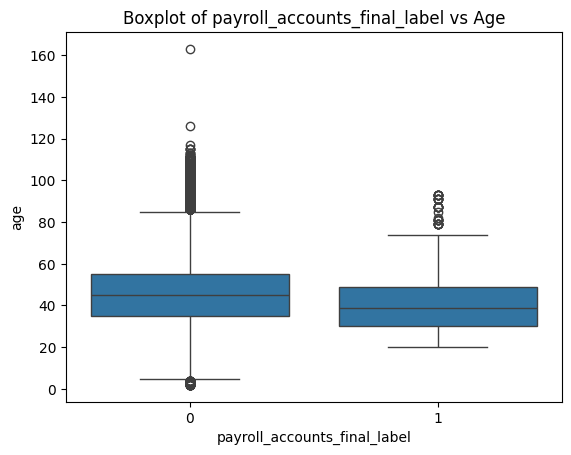

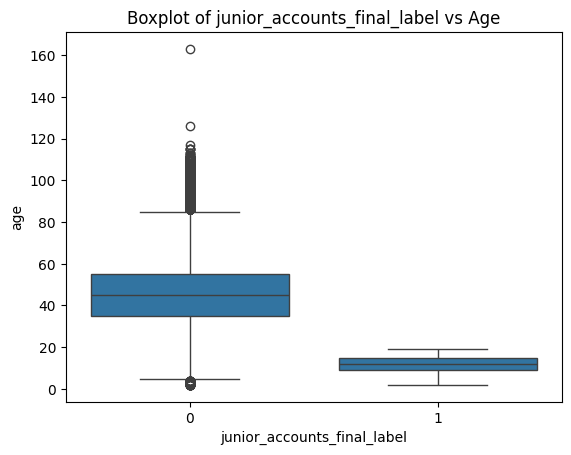

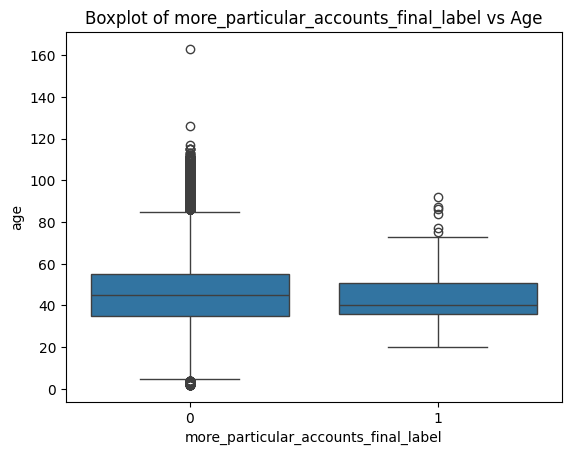

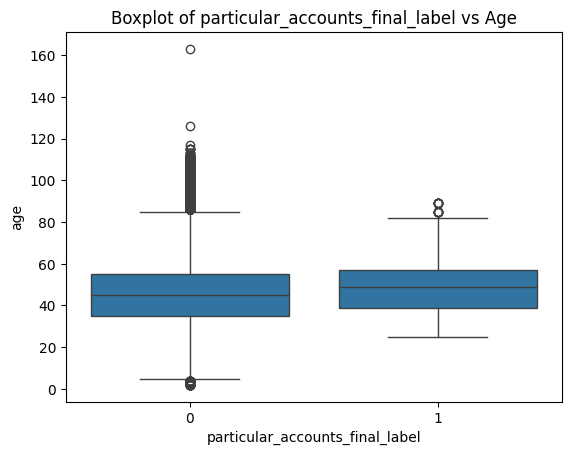

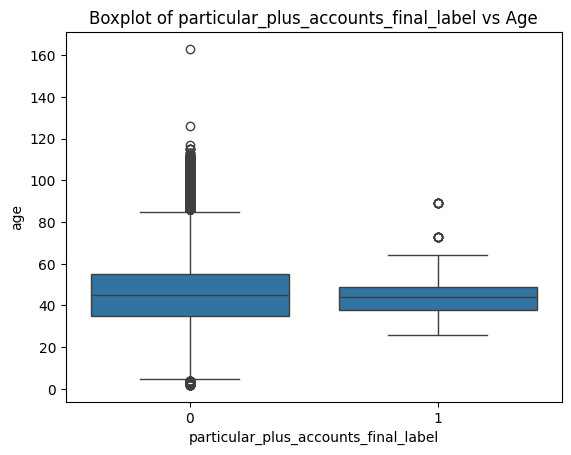

Column short_term_deposits_final_label not found in DataFrame.
Column medium_term_deposits_final_label not found in DataFrame.
Column long_term_deposits_final_label not found in DataFrame.


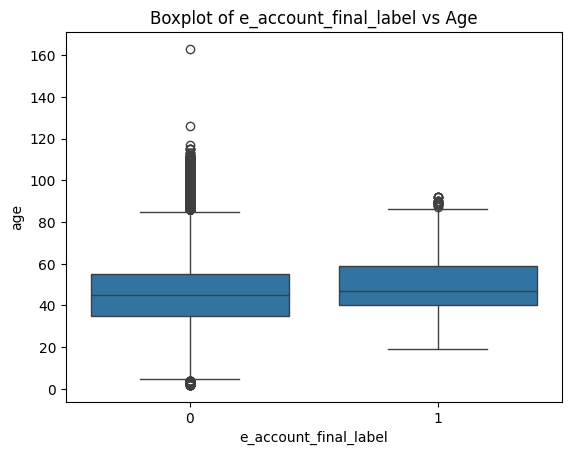

Column funds_final_label not found in DataFrame.
Column mortgage_final_label not found in DataFrame.
Column pensions_final_label not found in DataFrame.
Column loans_final_label not found in DataFrame.
Column taxes_final_label not found in DataFrame.
Column credit_card_final_label not found in DataFrame.
Column securities_final_label not found in DataFrame.


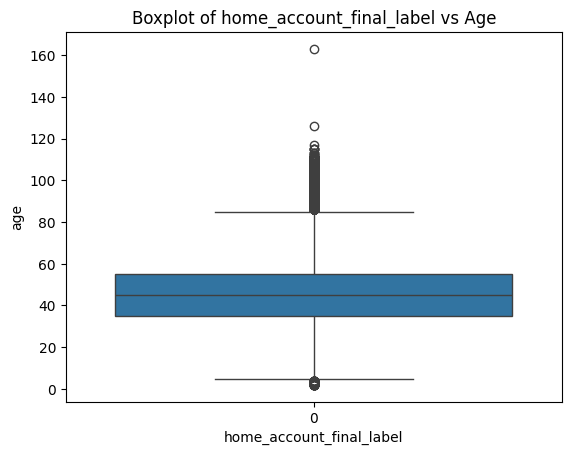

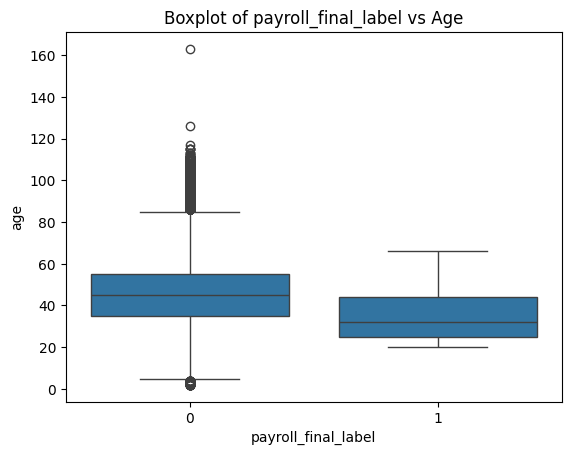

Column pensions_2_final_label not found in DataFrame.
Column direct_debit_final_label not found in DataFrame.


In [54]:
for col in target_cols:
    if col in df.columns:
        sns.boxplot(x=col, y="age", data=df)
        plt.title(f"Boxplot of {col} vs Age")
        plt.show()
    else:
        print(f"Column {col} not found in DataFrame.")


Column savings_account_final_label not found in DataFrame.
Column guarantees_final_label not found in DataFrame.


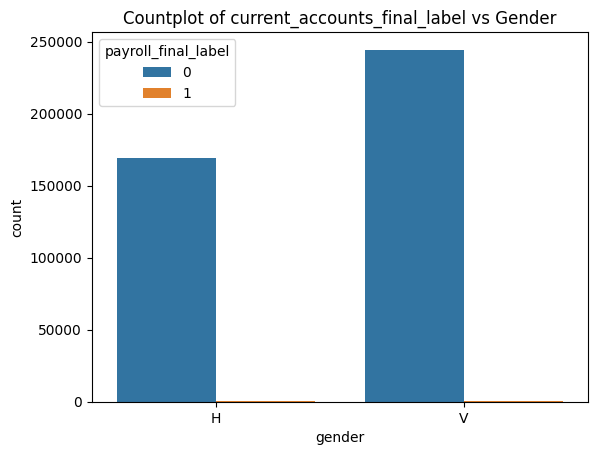

Column deriv_investments_final_label not found in DataFrame.


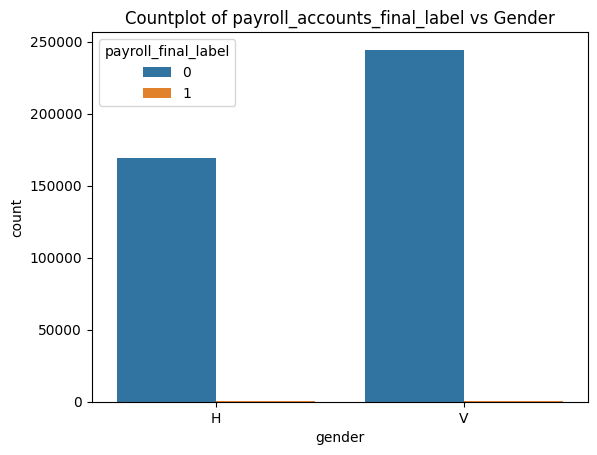

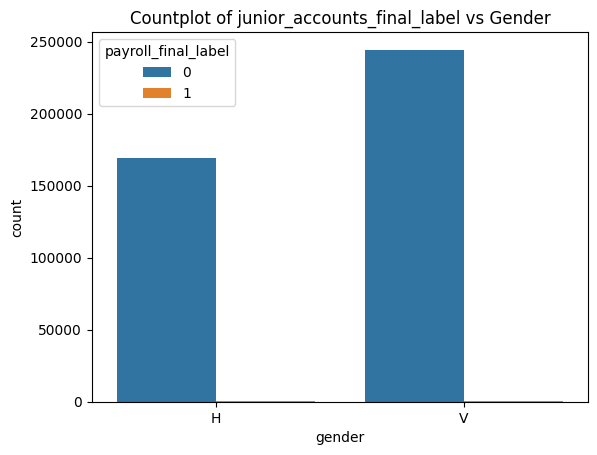

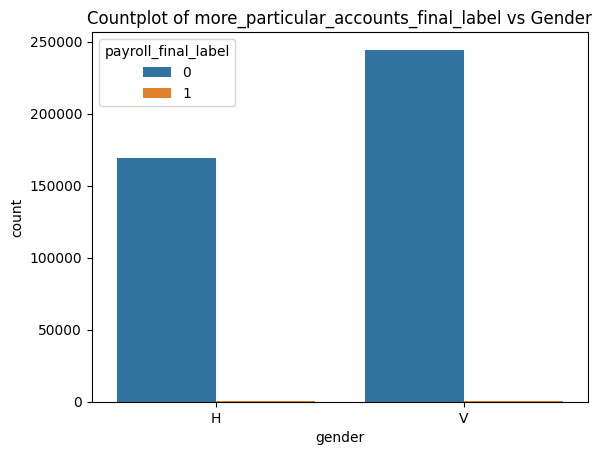

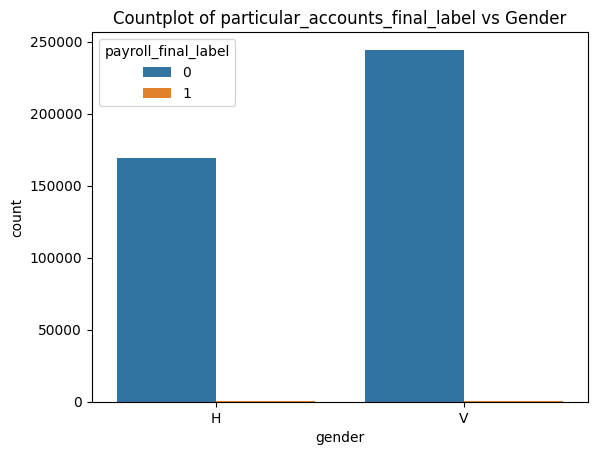

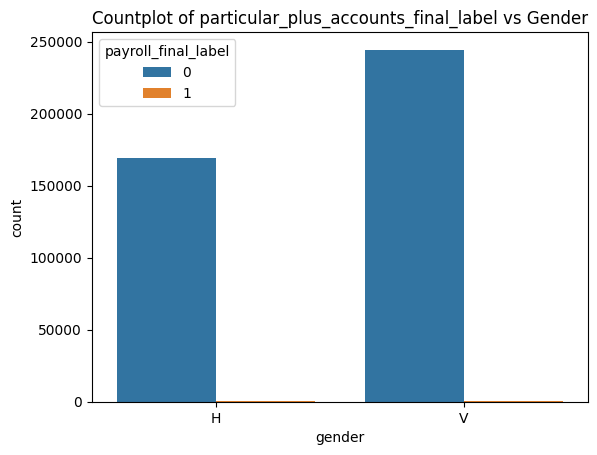

Column short_term_deposits_final_label not found in DataFrame.
Column medium_term_deposits_final_label not found in DataFrame.
Column long_term_deposits_final_label not found in DataFrame.


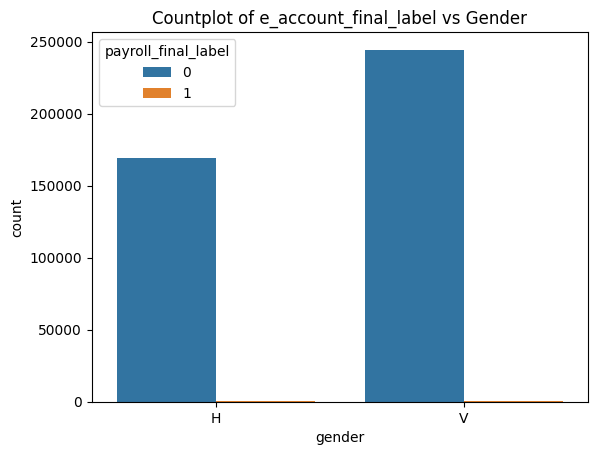

Column funds_final_label not found in DataFrame.
Column mortgage_final_label not found in DataFrame.
Column pensions_final_label not found in DataFrame.
Column loans_final_label not found in DataFrame.
Column taxes_final_label not found in DataFrame.
Column credit_card_final_label not found in DataFrame.
Column securities_final_label not found in DataFrame.


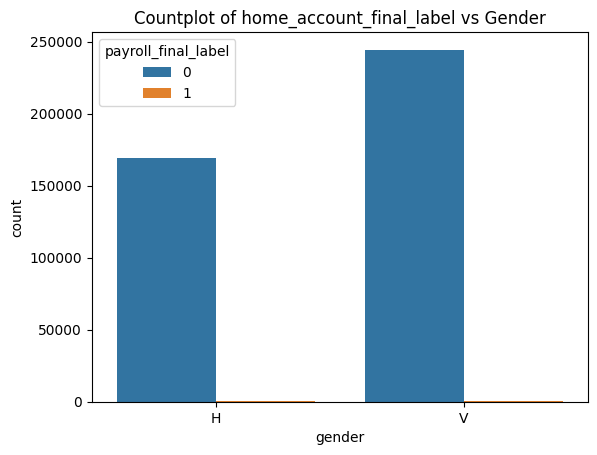

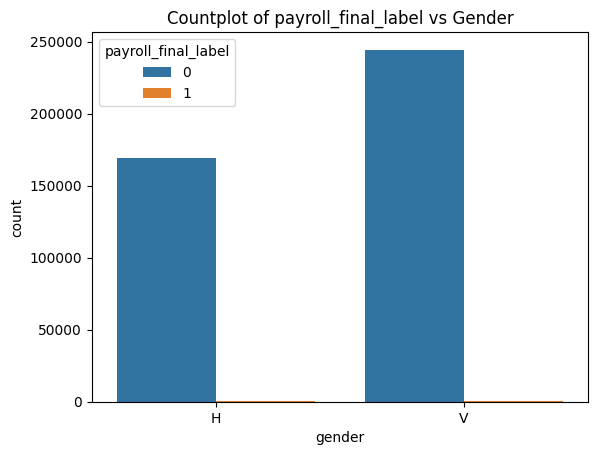

Column pensions_2_final_label not found in DataFrame.
Column direct_debit_final_label not found in DataFrame.


In [57]:

for col in target_cols:
    if col in df.columns:
        sns.countplot(x="gender", hue="payroll_final_label", data=df)
        plt.title(f"Countplot of {col} vs Gender")
        plt.show()
    else:
        print(f"Column {col} not found in DataFrame.")



Column savings_account_final_label not found in DataFrame.
Column guarantees_final_label not found in DataFrame.


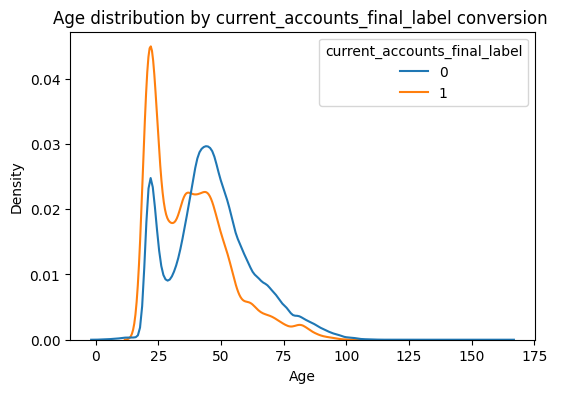

Column deriv_investments_final_label not found in DataFrame.


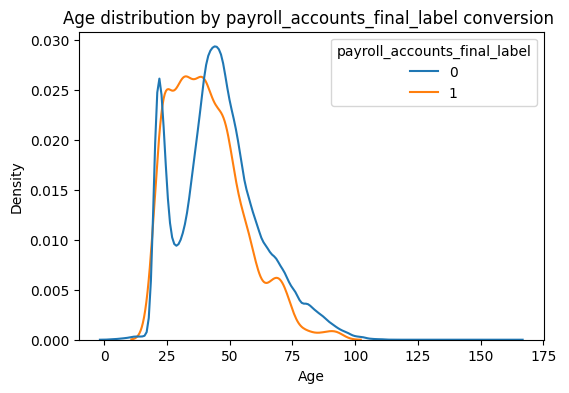

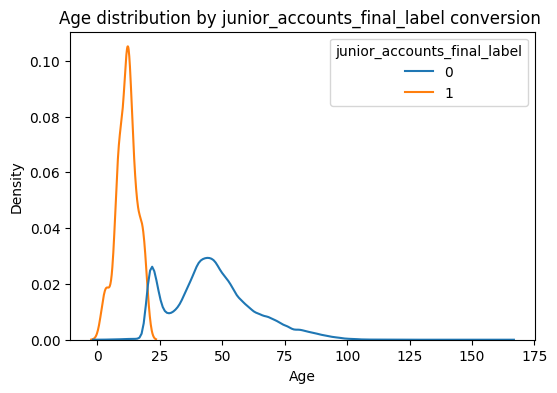

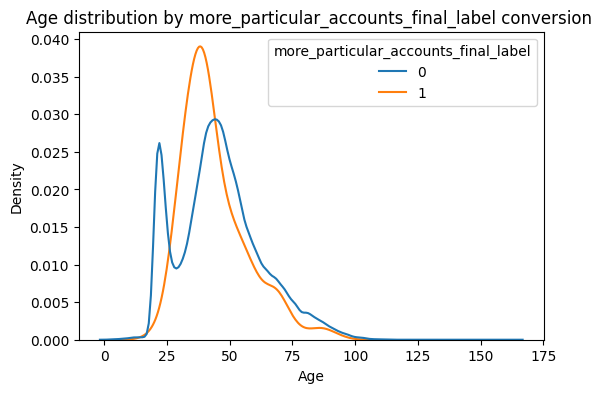

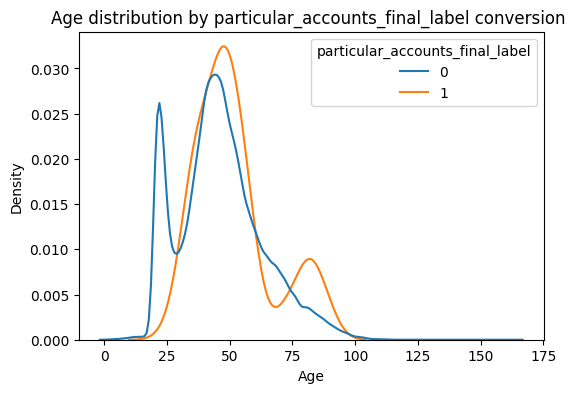

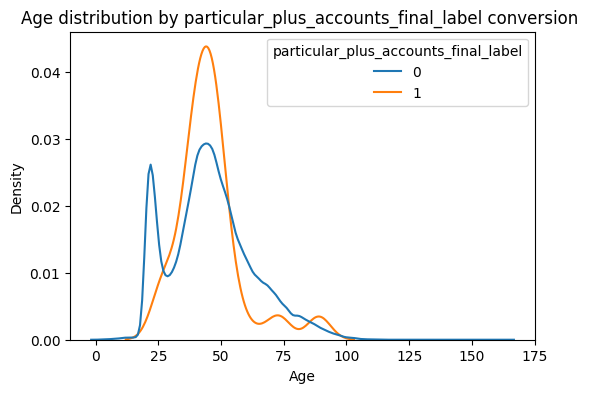

Column short_term_deposits_final_label not found in DataFrame.
Column medium_term_deposits_final_label not found in DataFrame.
Column long_term_deposits_final_label not found in DataFrame.


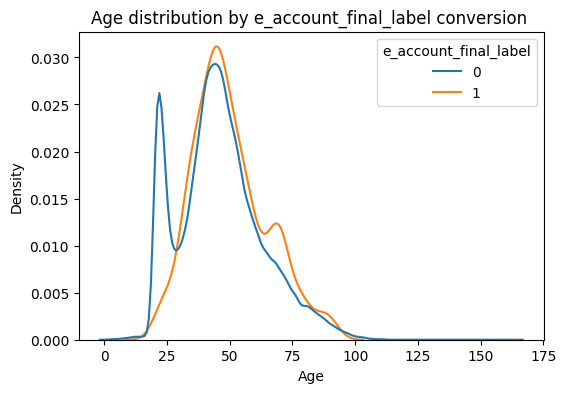

Column funds_final_label not found in DataFrame.
Column mortgage_final_label not found in DataFrame.
Column pensions_final_label not found in DataFrame.
Column loans_final_label not found in DataFrame.
Column taxes_final_label not found in DataFrame.
Column credit_card_final_label not found in DataFrame.
Column securities_final_label not found in DataFrame.


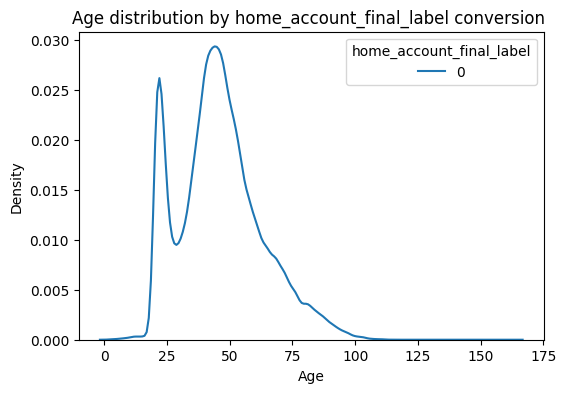

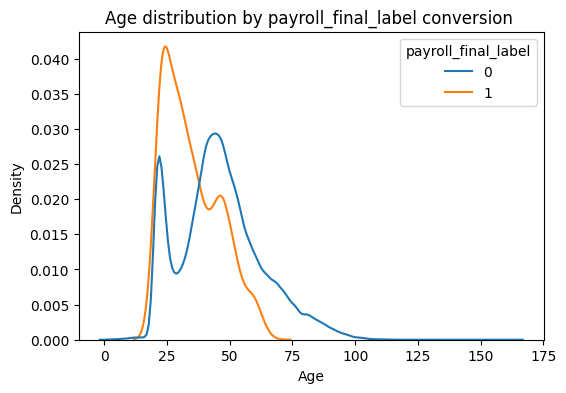

Column pensions_2_final_label not found in DataFrame.
Column direct_debit_final_label not found in DataFrame.


In [71]:

for col in target_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.kdeplot(data=df, x="age", hue=col, common_norm=False)
        plt.title(f"Age distribution by {col} conversion ")
        plt.xlabel("Age")
        plt.show()
    else:
        print(f"Column {col} not found in DataFrame.")



Column savings_account_final_label not found in DataFrame.
Column guarantees_final_label not found in DataFrame.


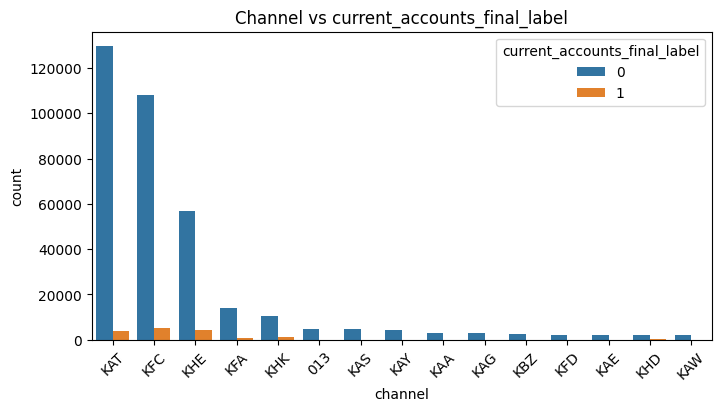

Column deriv_investments_final_label not found in DataFrame.


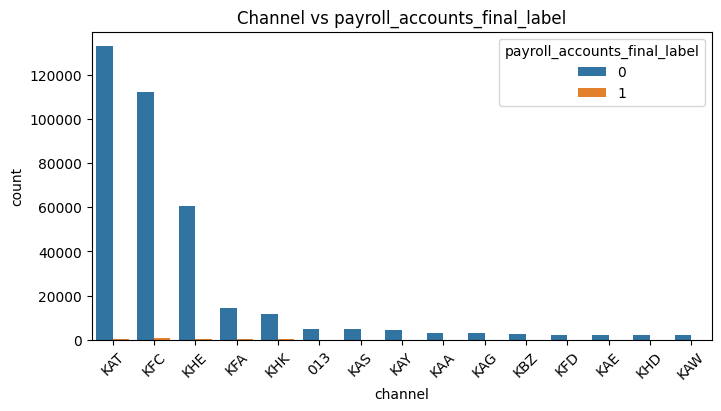

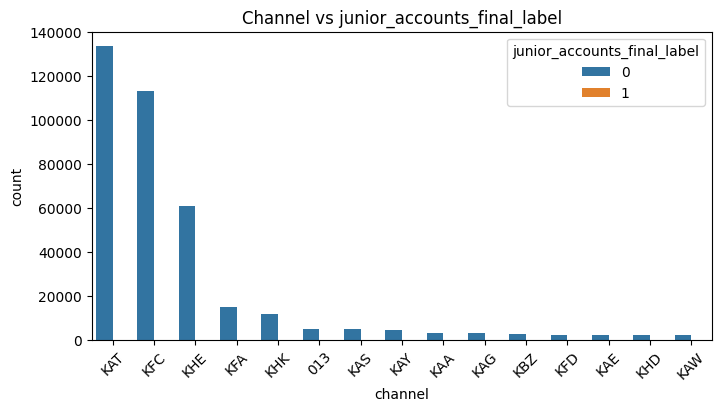

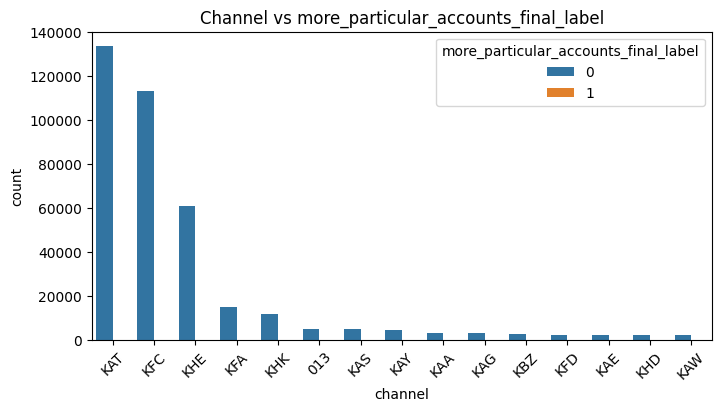

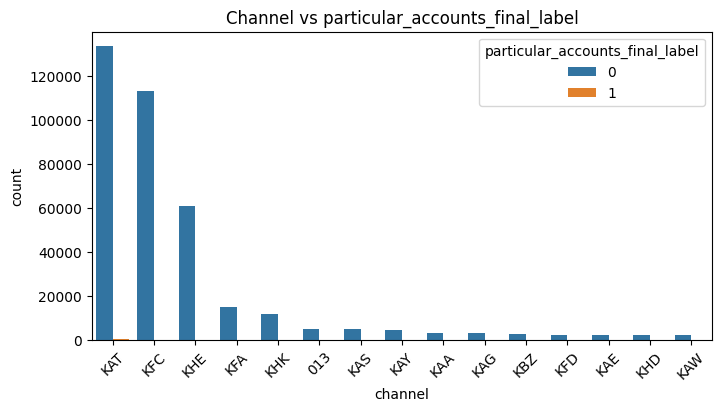

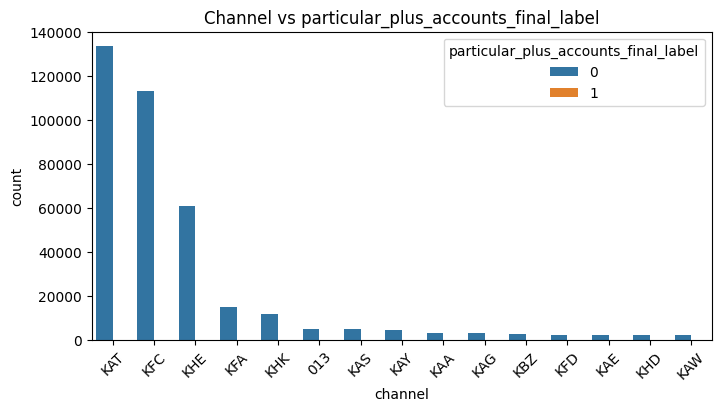

Column short_term_deposits_final_label not found in DataFrame.
Column medium_term_deposits_final_label not found in DataFrame.
Column long_term_deposits_final_label not found in DataFrame.


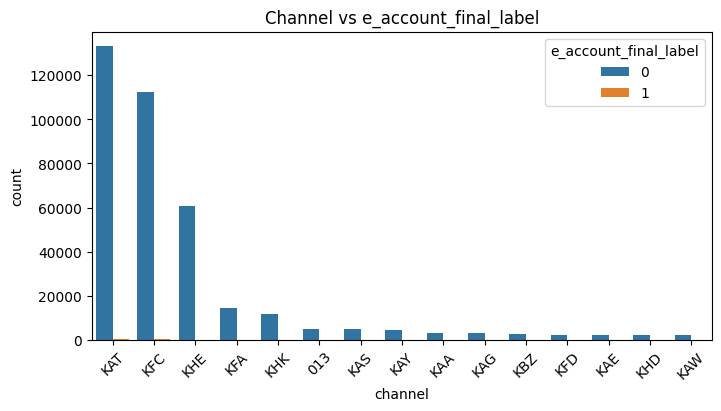

Column funds_final_label not found in DataFrame.
Column mortgage_final_label not found in DataFrame.
Column pensions_final_label not found in DataFrame.
Column loans_final_label not found in DataFrame.
Column taxes_final_label not found in DataFrame.
Column credit_card_final_label not found in DataFrame.
Column securities_final_label not found in DataFrame.


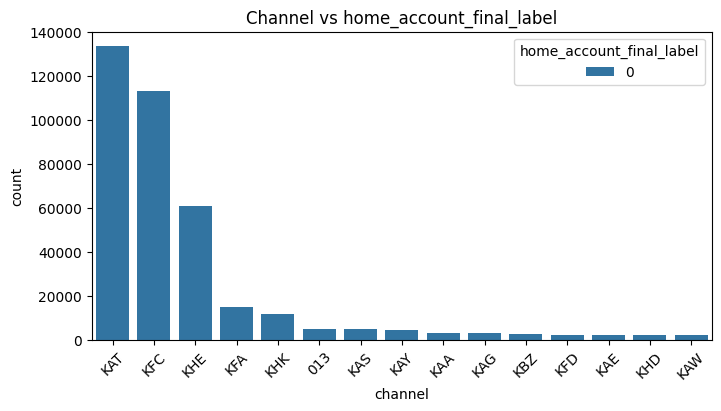

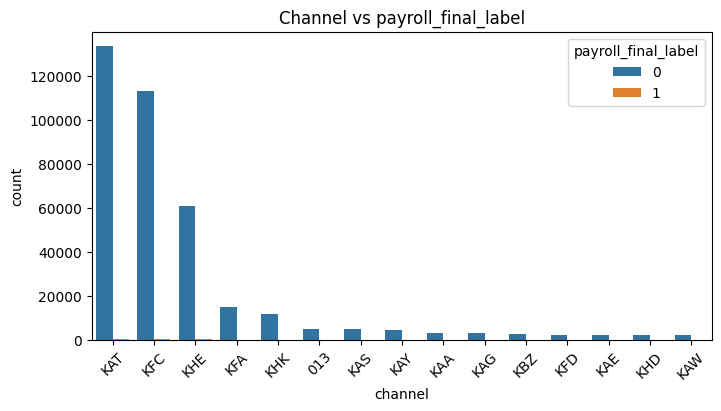

Column pensions_2_final_label not found in DataFrame.
Column direct_debit_final_label not found in DataFrame.


In [74]:
top_channels = df["channel"].value_counts().nlargest(15).index

for col in target_cols:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(x="channel", hue=col, data=df[df["channel"].isin(top_channels)], order=top_channels)
        plt.xticks(rotation=45)
        plt.title(f"Channel vs {col}")
        plt.show()
    else:
        print(f"Column {col} not found in DataFrame.")

Column savings_account_final_label not found in DataFrame.
Column guarantees_final_label not found in DataFrame.


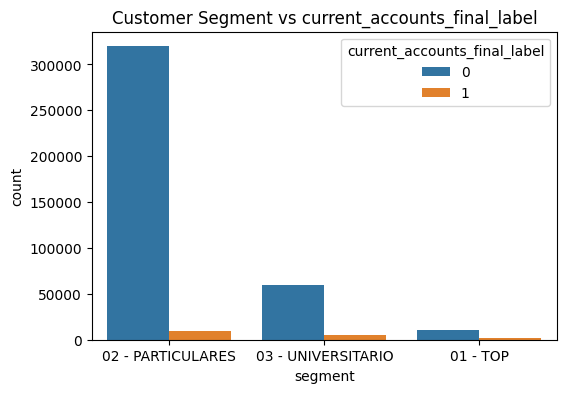

Column deriv_investments_final_label not found in DataFrame.


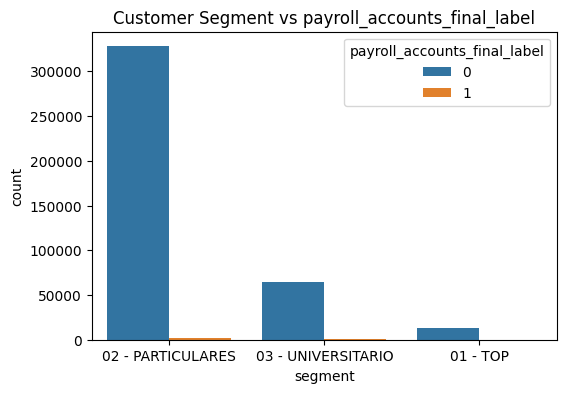

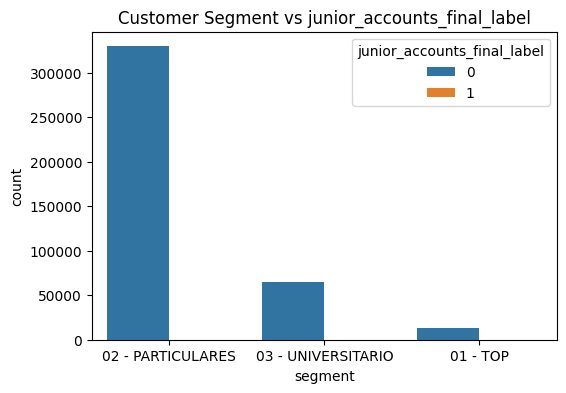

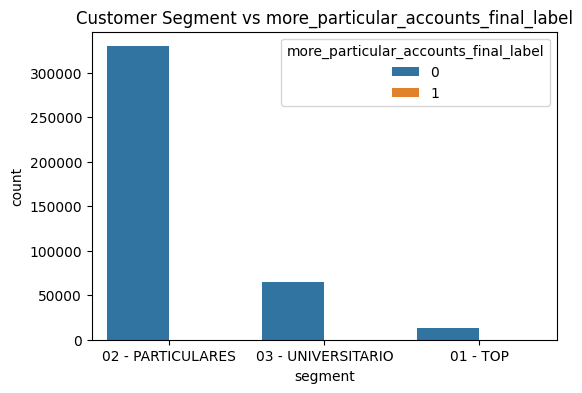

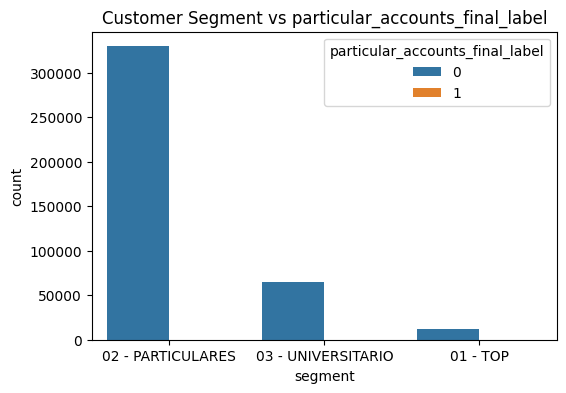

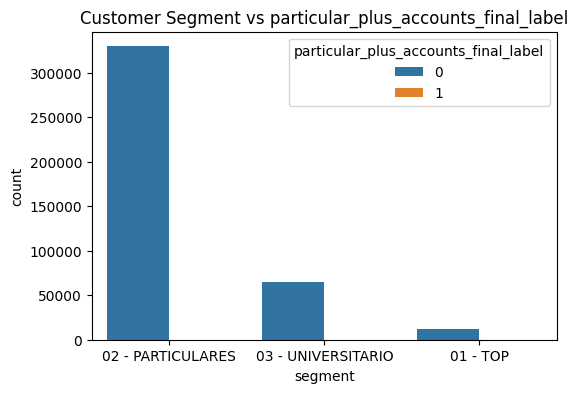

Column short_term_deposits_final_label not found in DataFrame.
Column medium_term_deposits_final_label not found in DataFrame.
Column long_term_deposits_final_label not found in DataFrame.


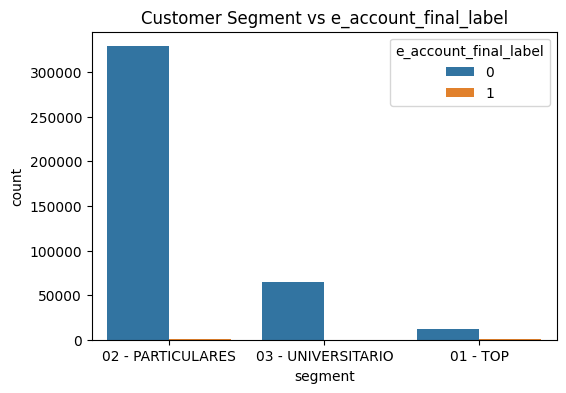

Column funds_final_label not found in DataFrame.
Column mortgage_final_label not found in DataFrame.
Column pensions_final_label not found in DataFrame.
Column loans_final_label not found in DataFrame.
Column taxes_final_label not found in DataFrame.
Column credit_card_final_label not found in DataFrame.
Column securities_final_label not found in DataFrame.


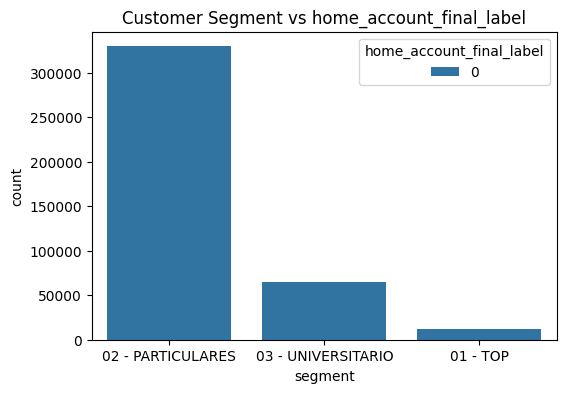

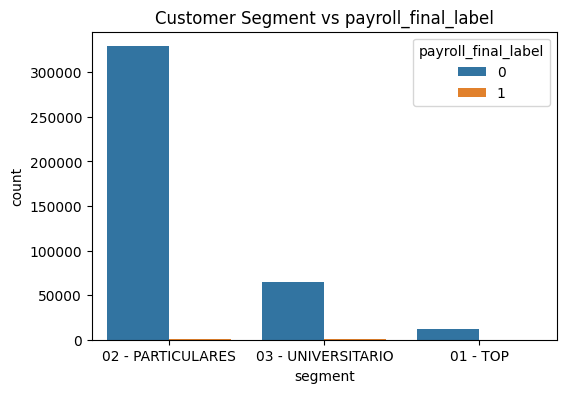

Column pensions_2_final_label not found in DataFrame.
Column direct_debit_final_label not found in DataFrame.


In [75]:
for col in target_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x="segment", hue=col, data=df, order=df["segment"].value_counts().index)
        plt.title(f"Customer Segment vs {col}")
        plt.show()
    else:
        print(f"Column {col} not found in DataFrame.")

Column savings_account_final_label not found in DataFrame.
Column guarantees_final_label not found in DataFrame.


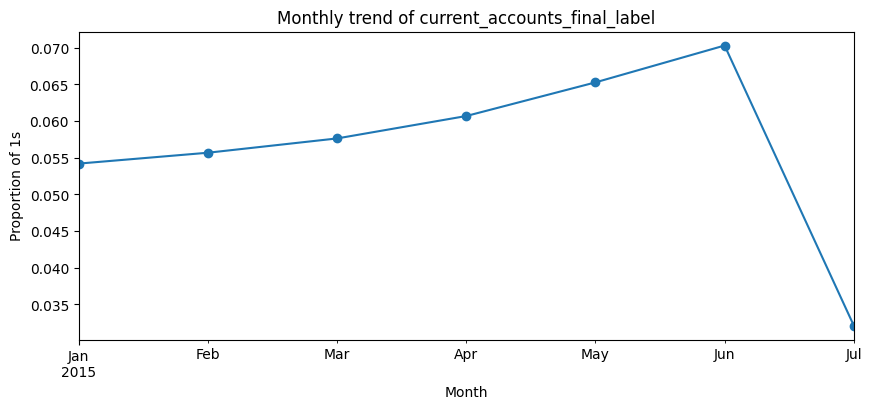

Column deriv_investments_final_label not found in DataFrame.


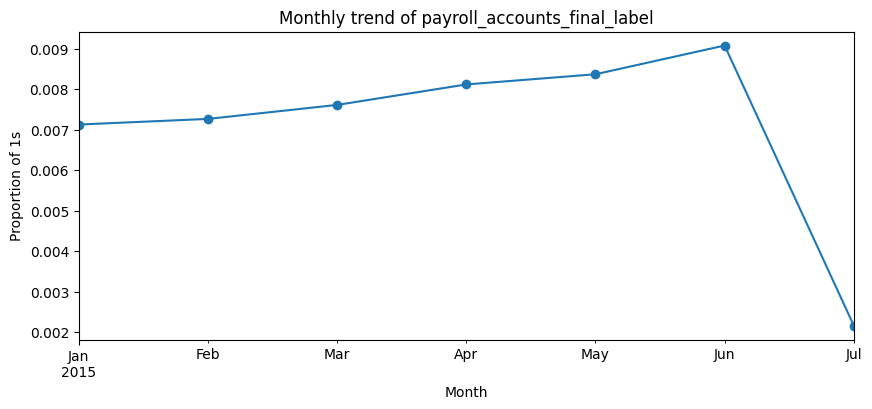

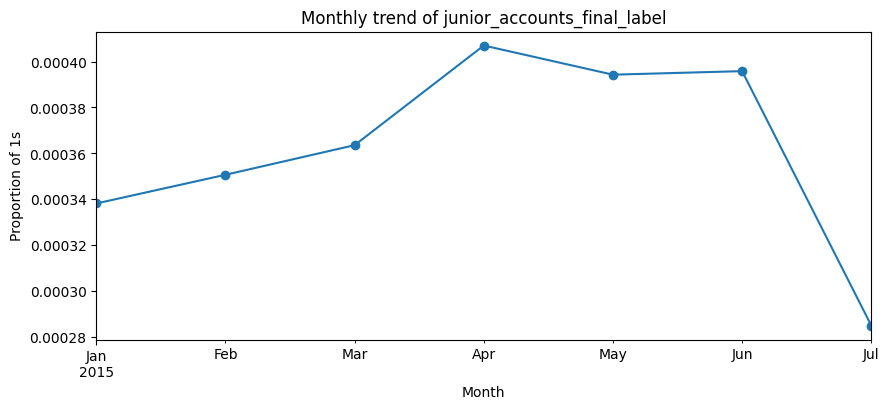

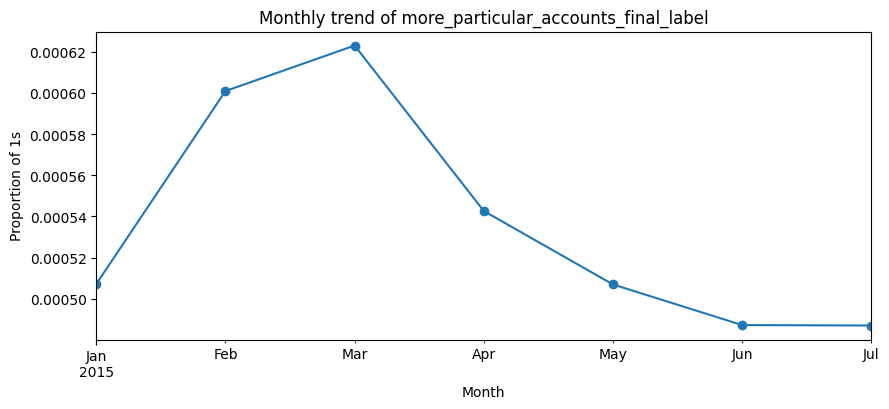

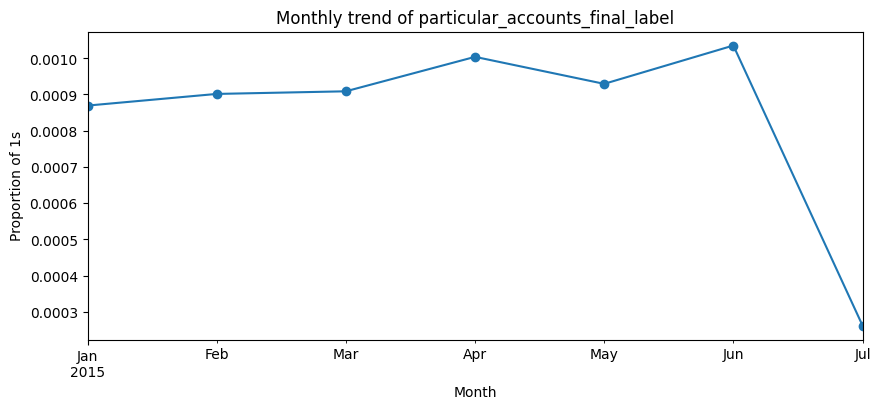

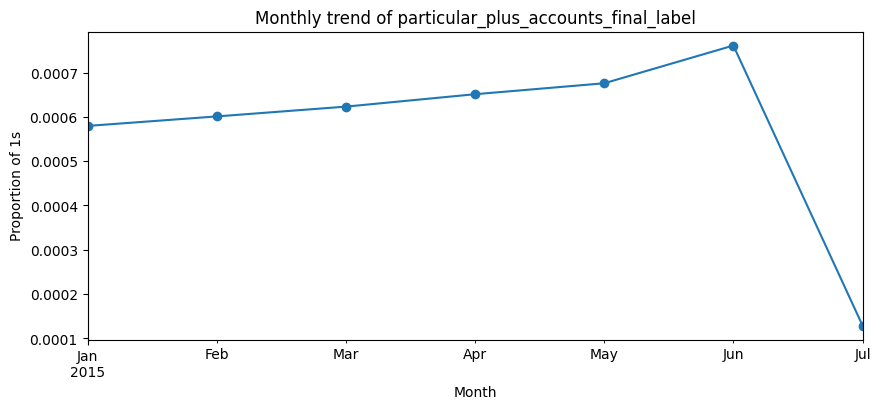

Column short_term_deposits_final_label not found in DataFrame.
Column medium_term_deposits_final_label not found in DataFrame.
Column long_term_deposits_final_label not found in DataFrame.


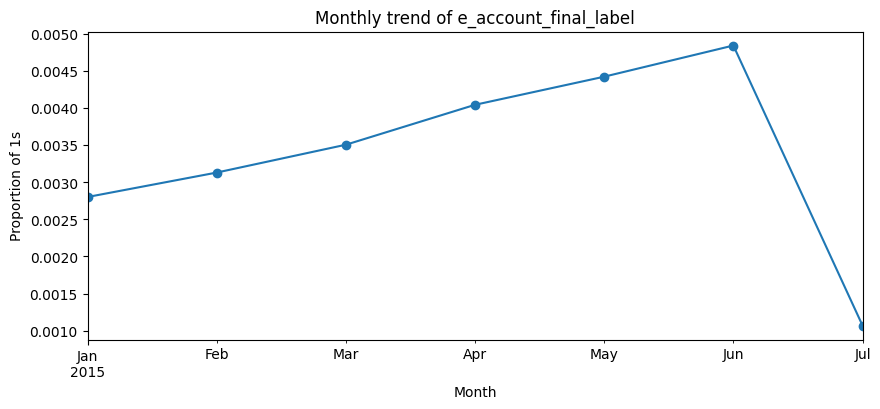

Column funds_final_label not found in DataFrame.
Column mortgage_final_label not found in DataFrame.
Column pensions_final_label not found in DataFrame.
Column loans_final_label not found in DataFrame.
Column taxes_final_label not found in DataFrame.
Column credit_card_final_label not found in DataFrame.
Column securities_final_label not found in DataFrame.


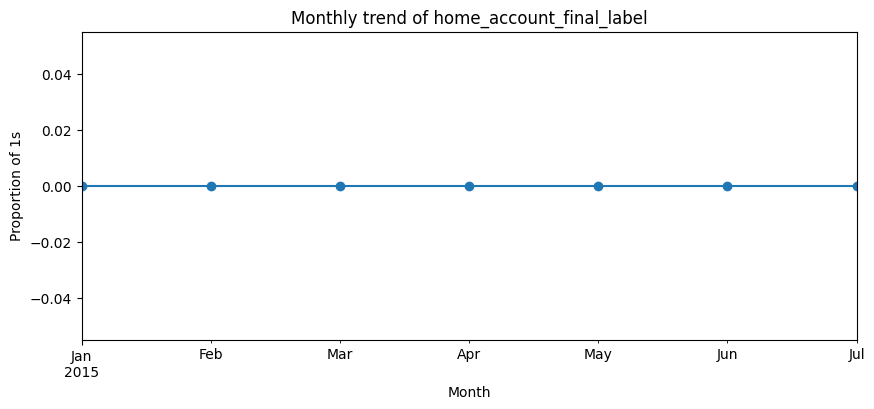

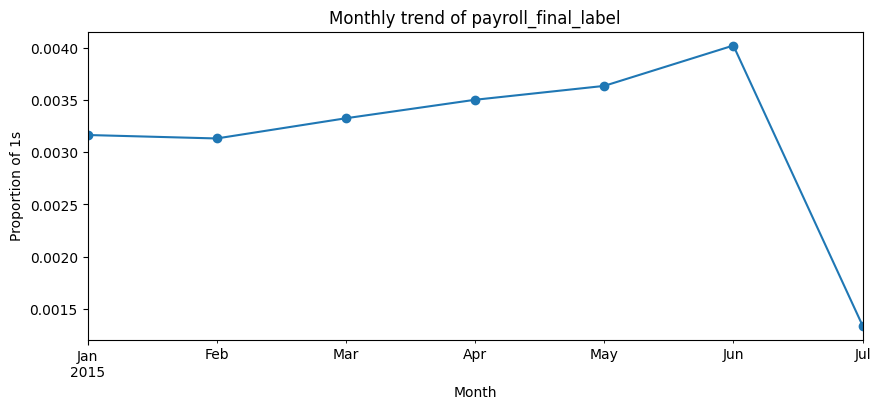

Column pensions_2_final_label not found in DataFrame.
Column direct_debit_final_label not found in DataFrame.


In [77]:
df["month"] = df["date"].dt.to_period("M")

for col in target_cols:
    if col in df.columns:
        monthly = df.groupby("month")[col].mean()
        plt.figure(figsize=(10,4))
        monthly.plot(kind="line", marker="o")
        plt.title(f"Monthly trend of {col}")
        plt.ylabel("Proportion of 1s")
        plt.xlabel("Month")
        plt.show()
    else:
        print(f"Column {col} not found in DataFrame.")
